# Imports

In [1]:
import json
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """Meant to encode time data with cycles (days of week, month...)"""
    def __init__(self, column_name, cycle_length):
        self.column_name = column_name
        self.cycle_length = cycle_length

    def fit(self, X, y=None):
        # No fitting needed, implemented for compatibility with sklearn's API
        return self

    def transform(self, X, y=None):
        # Apply cyclical encoding directly without needing to fit
        X = X.copy()
        values = X[self.column_name]
        # Create the cyclical features
        X[f'{self.column_name}_sin'] = np.sin(2 * np.pi * values / self.cycle_length)
        X[f'{self.column_name}_cos'] = np.cos(2 * np.pi * values / self.cycle_length)
        # Drop the original column
        X.drop(columns=[self.column_name], inplace=True)
        return X

    def get_feature_names_out(self, input_features=None):
        # Generate names for the output features
        return np.array(
          [f'{self.column_name}_sin', f'{self.column_name}_cos'], dtype=object
        )

# Data Loading

In [3]:
%%time
df = pd.read_csv("../cleandata.csv", index_col=0)

CPU times: total: 1.31 s
Wall time: 1.31 s


# Droping Useless Columns

In [4]:
df.sample()

,State,Bank,BankState,Term,NoEmp,NewExist,CreateJob,RetainedJob,Franchised,UrbanRural,...,MIS_Status,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,ApprovalDoW,ApprovalYear,Recession,NAICS,SameState
City,,,,,,,,,,,,,,,,,,,,,
PLYMPTON,MA,CITIZENS BANK NATL ASSOC,RI,60,5,False,0,5,0,U,...,PIF,38000.0,19000.0,7,1,4,2005,False,81,False


# Separating Features and Target

In [5]:
X = df.copy()
y = X.pop("MIS_Status")

# Hold-Out

In [6]:
# Stratify with y by default
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.05,
                                                    stratify=y,
                                                    random_state=42)

# Model

## Preprocessing

In [7]:
# Splitting columns
num_cols = ["Term", "NoEmp", "CreateJob", "RetainedJob",
            "GrAppv", "SBA_Appv"]

cyc_cols = ["ApprovalMonth", "ApprovalDoW"]

nom_cols = ["Bank", "BankState", "Franchised", "LowDoc", "NAICS",
            "NewExist", "Recession", "RevLineCr", "SameState", "State", "UrbanRural"]

In [8]:
std_scl = StandardScaler()
cyc_dow = CyclicalEncoder("ApprovalDoW", 7)
cyc_mth = CyclicalEncoder("ApprovalMonth", 12)

In [9]:
preproc = ColumnTransformer(
    transformers = [
        ("num", std_scl, num_cols),
        ("cyc_mth", cyc_mth, ["ApprovalMonth"]),
        ("cyc_dow", cyc_dow, ["ApprovalDoW"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)
preproc.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Term', 'NoEmp', 'CreateJob', 'RetainedJob',
                                  'GrAppv', 'SBA_Appv']),
                                ('cyc_mth',
                                 CyclicalEncoder(column_name='ApprovalMonth',
                                                 cycle_length=12),
                                 ['ApprovalMonth']),
                                ('cyc_dow',
                                 CyclicalEncoder(column_name='ApprovalDoW',
                                                 cycle_length=7),
                                 ['ApprovalDoW'])],
                  verbose_feature_names_out=False)

In [10]:
X_train_tr = preproc.fit_transform(X_train)
# X_train_tr

In [11]:
nom_indexes = [idx for idx, col in enumerate(X_train_tr.dtypes)
               if col == "object"]
nom_indexes

[10, 11, 12, 15, 16, 17]

## Estimator

In [12]:
train_pool = Pool(data=X_train_tr,
                  label=y_train, 
                  cat_features=nom_indexes,
                  feature_names=X_train_tr.columns.to_list())

cb = CatBoostClassifier(cat_features=nom_cols, eval_metric="TotalF1")

In [13]:
model = make_pipeline(preproc, cb)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Term', 'NoEmp', 'CreateJob',
                                                   'RetainedJob', 'GrAppv',
                                                   'SBA_Appv']),
                                                 ('cyc_mth',
                                                  CyclicalEncoder(column_name='ApprovalMonth',
                                                                  cycle_length=12),
                                                  ['ApprovalMonth']),
                                                 ('cyc_dow',
                                                  CyclicalEncoder(column_name='ApprovalDoW',
                                                                  cycle_length=7),
                                                  ['ApprovalDoW'])],
                                   verbose_feature_names_out=False)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001699364CF50>)])

## Training & Score

In [14]:
%%time
# Not performed for memory gain
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
raw_score = f1_score(y_test, y_pred, average="macro")
raw_score

Learning rate set to 0.183754
0:	learn: 0.8930522	total: 831ms	remaining: 13m 49s
1:	learn: 0.8965748	total: 1.51s	remaining: 12m 33s
2:	learn: 0.8985435	total: 2.07s	remaining: 11m 28s
3:	learn: 0.9025510	total: 2.67s	remaining: 11m 5s
4:	learn: 0.9103009	total: 3.25s	remaining: 10m 46s
5:	learn: 0.9115989	total: 3.89s	remaining: 10m 44s
6:	learn: 0.9119349	total: 4.47s	remaining: 10m 34s
7:	learn: 0.9135718	total: 5.07s	remaining: 10m 28s
8:	learn: 0.9147856	total: 5.8s	remaining: 10m 38s
9:	learn: 0.9189322	total: 6.45s	remaining: 10m 38s
10:	learn: 0.9207335	total: 7.12s	remaining: 10m 40s
11:	learn: 0.9244817	total: 7.7s	remaining: 10m 34s
12:	learn: 0.9253912	total: 8.26s	remaining: 10m 27s
13:	learn: 0.9275879	total: 8.83s	remaining: 10m 22s
14:	learn: 0.9292370	total: 9.39s	remaining: 10m 16s
15:	learn: 0.9303464	total: 10s	remaining: 10m 15s
16:	learn: 0.9318070	total: 10.6s	remaining: 10m 14s
17:	learn: 0.9336778	total: 11.2s	remaining: 10m 10s
18:	learn: 0.9339121	total: 11.

0.9416794988014534

In [15]:
# EN NE TOUCHANT A RIEN ON OBTIENT : 0.941679
# EN SUPPRIMANT SameState ON OBTIENT : 0.941555

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      CHGOFF       0.93      0.88      0.90      8122
         PIF       0.97      0.98      0.98     36722

    accuracy                           0.97     44844
   macro avg       0.95      0.93      0.94     44844
weighted avg       0.97      0.97      0.97     44844



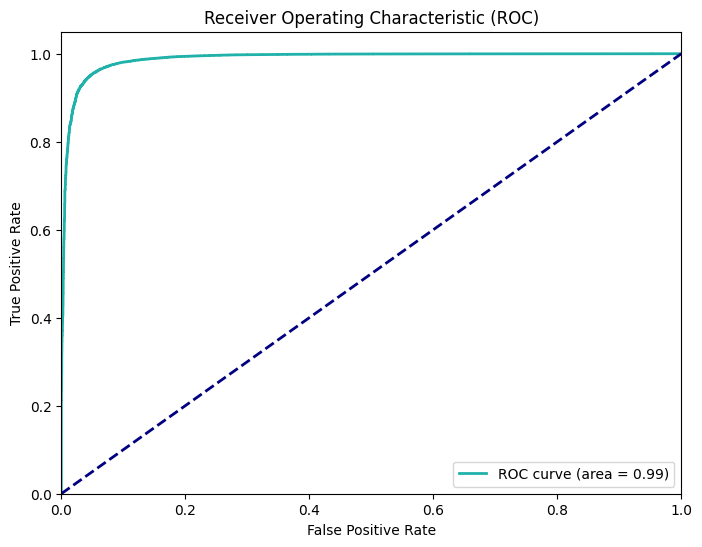

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_test_binary = np.where(y_test == 'PIF', 1, 0)

# Calculer le taux de faux positifs, le taux de vrais positifs et les seuils à partir des prédictions binaires
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)

# Calculer l'AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightseagreen', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [31]:
import pickle 
# Sauvegarde du modèle en fichier .pkl
with open('modele.pkl', 'wb') as file:
    pickle.dump(model, file)

In [32]:
cb_all_params = model[-1].get_all_params()

In [33]:
params = [
    'iterations',
    'depth',
    'learning_rate',
    'random_strength',
    'bagging_temperature',
    'border_count',
    'l2_leaf_reg',
    # 'scale_pos_weight'
]

In [34]:
cb_raw_params = {param: cb_all_params.get(param, "Not found")
                for param in params}
cb_raw_params["f1_macro"] = raw_score
cb_raw_params

{'iterations': 1000,
 'depth': 6,
 'learning_rate': 0.18375399708747864,
 'random_strength': 1,
 'bagging_temperature': 'Not found',
 'border_count': 254,
 'l2_leaf_reg': 3,
 'f1_macro': 0.9416794988014534}

In [35]:
# {'iterations': 1000,
#  'depth': 6,
#  'learning_rate': 0.18375399708747864,
#  'random_strength': 1,
#  'bagging_temperature': 'Not found',
#  'border_count': 254,
#  'l2_leaf_reg': 3,
#  'f1_macro': 0.9357768474158076}

In [36]:
# {'border_count': 214,
#  'depth': 4,
#  'l2_leaf_reg': 8,
#  'iterations': 1000,
#  'bagging_temperature': 0.21416669906304386,
#  'random_strength': 3.710936258235652e-09,
#  'learning_rate': 0.12620540388615334
#  'f1_macro' : 0.9297395128284291}

In [37]:
# with open("../catboost_raw_params.json", "w") as dump_file:
#     json.dump(cb_raw_params, dump_file, indent=4)

# Randomized Search

## Config & Launch

In [38]:
# param_distributions = {
#     'iterations': [1_000],
#     'depth': np.arange(1, 9),
#     'learning_rate': loguniform(0.01, 1.0),
#     'random_strength': loguniform(1e-9, 10),
#     'bagging_temperature': uniform(0, 1),
#     'border_count': np.arange(1, 256),
#     'l2_leaf_reg': np.arange(2, 31),
#     # 'scale_pos_weight': np.arange(0.01, 10, 0.01),
# }

In [39]:
# train_pool = Pool(data=X_train_tr,
#                   label=y_train, 
#                   cat_features=nom_indexes,
#                   feature_names=X_train_tr.columns.to_list())

# cb = CatBoostClassifier(cat_features=nom_cols,
#                         eval_metric="TotalF1")

In [40]:
# %%time
# search_results = cb.randomized_search(
#     param_distributions,
#     X=X_train_tr,
#     y=y_train,
#     cv=5,
#     n_iter=3,
#     partition_random_seed=42,
#     verbose=True
# )

In [41]:
# CODE A DECOMMENTER
# best_params = search_results['params']
# best_params

# RESULTAT 
# bestTest = 0.9561955481
# bestIteration = 998

# {'border_count': 214,
#  'depth': 4,
#  'l2_leaf_reg': 8,
#  'iterations': 1000,
#  'bagging_temperature': 0.21416669906304386,
#  'random_strength': 3.710936258235652e-09,
#  'learning_rate': 0.12620540388615334}

In [42]:
# The model is already updated with the best parameters
# X_test_tr = model[:-1].transform(X_test)
# y_pred = cb.predict(X_test_tr)
# gs_score = f1_score(y_test, y_pred, average="macro")

## Getting Results

In [43]:
cb_gs_params = {k: v for k, v in best_params.items()
                if k in params}
cb_gs_params['f1_macro'] = gs_score
cb_gs_params['f1_macro']

NameError: name 'best_params' is not defined

In [ ]:
with open("../catboost_rs_params.json", "w") as dump_file:
    json.dump(cb_gs_params, dump_file, indent=4)